<a href="https://colab.research.google.com/github/ray-mainah/NAIROBI_UHI/blob/main/UHI_Nairobi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import ee
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

In [ ]:
ee.Authenticate()
ee.Initialize(project='ee-raymainh24')

Define Nairobi Boundary from GEE Feature Collection

In [ ]:
import geemap

Map = geemap.Map()

# Load Nairobi boundary from GEE FeatureCollection
nairobi = ee.FeatureCollection("FAO/GAUL/2015/level2") \
    .filter(ee.Filter.eq('ADM2_NAME', 'Nairobi'))

Map.centerObject(nairobi, 10)
Map.addLayer(nairobi, {}, "Nairobi Boundary")
Map


Map(center=[-1.2899557190767565, 36.86835227030284], controls=(WidgetControl(options=['position', 'transparent…

Retrieve Satellite Data for LST & NDVI

In [ ]:
def maskL8sr_c2(image):
    # Cloud mask from QA_PIXEL band
    qa_pixel = image.select('QA_PIXEL')
    cloud_shadow_bit = 3
    cloud_bit = 4

    # Mask out clouds and cloud shadows
    mask = qa_pixel.bitwiseAnd(1 << cloud_shadow_bit).eq(0) \
        .And(qa_pixel.bitwiseAnd(1 << cloud_bit).eq(0))

    # Apply scaling factors (from metadata)
    optical_bands = image.select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5']) \
                         .multiply(0.0000275).add(-0.2)

    return optical_bands.updateMask(mask).copyProperties(image, image.propertyNames())



In [ ]:
# Reload Landsat 8 Collection 2 data
landsat_sr = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(nairobi) \
    .filterDate('2023-01-01', '2023-12-31') \
    .select(['SR_B5', 'SR_B4']) \
    .median() \
    .clip(nairobi)

# Apply scale factor to convert to reflectance
scaled_sr = landsat_sr.multiply(0.0000275).add(-0.2)

# Calculate NDVI: (NIR - RED) / (NIR + RED)
ndvi = scaled_sr.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

# Visualize NDVI
ndvi_vis = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'green', 'yellow']
}

Map.addLayer(ndvi, ndvi_vis, 'NDVI (2023)')
Map


Map(bottom=132311.0, center=[-1.2899557190767565, 36.86835227030284], controls=(WidgetControl(options=['positi…

Calculate LST from Landsat 8 Collection 2

In [ ]:
# Load Landsat 8 C2 L2 data again
thermal = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(nairobi) \
    .filterDate('2023-01-01', '2023-12-31') \
    .select('ST_B10') \
    .median() \
    .clip(nairobi)

# Apply scale factor from USGS docs: scale = 0.00341802, offset = 149.0
# But for surface temp band (ST_B10), the scale is 0.00341802
lst_kelvin = thermal.multiply(0.00341802).add(149.0)

# Convert to Celsius
lst_celsius = lst_kelvin.subtract(273.15)

# Visualization parameters
lst_vis = {
    'min': 15,
    'max': 45,
    'palette': ['blue', 'cyan', 'green', 'yellow', 'red']
}

# Display
Map.addLayer(lst_celsius, lst_vis, 'Land Surface Temperature (°C)')
Map


Map(bottom=132311.0, center=[-1.2899557190767565, 36.86835227030284], controls=(WidgetControl(options=['positi…

Export NDVI and LST Maps to Google Drive

In [ ]:
export_ndvi = ee.batch.Export.image.toDrive(
    image=ndvi.toFloat(),
    description='Nairobi_NDVI_2023',
    folder='GEE_Exports',
    fileNamePrefix='Nairobi_NDVI_2023',
    region=nairobi.geometry(),
    scale=30,
    maxPixels=1e13
)
export_ndvi.start()


LST

In [ ]:
export_lst = ee.batch.Export.image.toDrive(
    image=lst_celsius.toFloat(),
    description='Nairobi_LST_2023',
    folder='GEE_Exports',
    fileNamePrefix='Nairobi_LST_2023',
    region=nairobi.geometry(),
    scale=30,
    maxPixels=1e13
)
export_lst.start()


Correlation Analysis Between NDVI and LST

In [ ]:
#Sample NDVI & LST Values Together

# Stack NDVI and LST into one image
combined = ndvi.addBands(lst_celsius).rename(['NDVI', 'LST'])

# Generate 500 random sample points in Nairobi
points = combined.sample(
    region=nairobi.geometry(),
    scale=30,
    numPixels=500,
    seed=42,
    geometries=True
)


In [ ]:
# Export Sample Points to CSV

# Export sample data as CSV to Google Drive
task = ee.batch.Export.table.toDrive(
    collection=points,
    description='NDVI_LST_Samples_Nairobi',
    folder='GEE_Exports',
    fileNamePrefix='NDVI_LST_Samples',
    fileFormat='CSV'
)
task.start()


In [ ]:
# Upload the CSV manually
uploaded = files.upload()


Saving NDVI_LST_Samples.csv to NDVI_LST_Samples.csv


Analysis

Correlation between NDVI and LST: 0.273


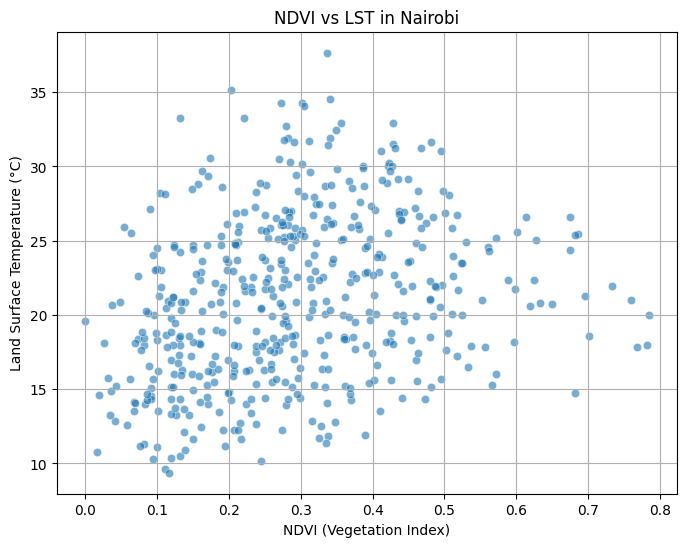

In [ ]:
# Load the CSV
df = pd.read_csv('NDVI_LST_Samples.csv')

# Clean the DataFrame
df = df[['NDVI', 'LST']].dropna()

# Correlation
corr = df.corr().loc['NDVI', 'LST']
print(f"Correlation between NDVI and LST: {corr:.3f}")

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='NDVI', y='LST', data=df, alpha=0.6)
plt.title('NDVI vs LST in Nairobi')
plt.xlabel('NDVI (Vegetation Index)')
plt.ylabel('Land Surface Temperature (°C)')
plt.grid(True)
plt.show()


In [ ]:
# Load Kenya admin boundaries from FAO GAUL (level 2 = sub-counties)
kenya_admin2 = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2")

# Filter for Nairobi County (level 1 is counties)
nairobi_subcounties = kenya_admin2.filter(ee.Filter.eq('ADM1_NAME', 'Nairobi'))

# Add to map
Map.addLayer(nairobi_subcounties, {'color': 'black'}, 'Nairobi Sub-counties')
Map

Map(bottom=132311.0, center=[-1.2899557190767565, 36.86835227030284], controls=(WidgetControl(options=['positi…